In [109]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [128]:
#function that calculates the theta state for particle
#### to do #### this function has to be redesigned includes forces on all particles
    #define a new function field_theta which represents angular position vector field
        #n = number of particles
        #include constraints for spacings between particles
            #constraint theta_2 = theta_1 + spacing_difference
        #return list of theta positions, number if porticles

def field_point_angular_positions(theta_0, n):
    angular_positions = []
    angular_spacing = 2 *np.pi/n
    for i in range(n):
        theta_i = theta_0 +(i)*angular_spacing
        angular_positions.append(theta_i)
    return angular_positions

In [127]:
#constants, coefficients for the wheel
a = 1
R = 5
F_0 = 5
m = 1
#mass constraint

phi = np.arccos(a/R)

#number of iterations to check if between -phi to phi
iterations = 4

coefficient_drag_water = 5/10
coefficient_drag_air = 1/10
mechanical_friction = 1/10

In [129]:
#represents the vector theta which is the angular position, angular velocity and angular acceleration in vector form
#because of the rigid rotor constraints, all particles move at the same angular velocity and maintain equal
#spacings from each other therefore calculating only the theta vector of the particle is necessary
def vector_theta_set_drag(theta_0, theta_0_prime, theta_0_double_prime, time_step, angular_positions):
    #first theta component representing angular position
    theta_0 = theta_0 + theta_0_prime * time_step #the current angle
    if theta_0 > 2*np.pi - phi:
        theta_0 = -phi

    #second theta component representing angular velocity
    theta_0_prime = theta_0_prime + theta_0_double_prime * time_step #speed of the angle

    #third theta component representing angular acceleration
    ### this part of the function now includes the vector angular position field and checks the field to see how
    ### many particles are between -phi and phi, ie in the water, and the forces acting on them
    ### the forces are assumed be additive (find right words)

    summation_theta_double_primes = []
    for theta_i in angular_positions:
    #checks the number of iterations cycles to see if it is between 2pi intervals of the range -phi to phi#basically checks if its in the water or not, do not make iterations too high as it doesn't take long for#the system to reach stability
        for i in range(iterations):
            if (theta_i >= -phi +  2*i*np.pi) and (theta_i < phi + 2*i*np.pi):
                theta_i_double_prime = F_0/(m*R)*(np.cos(theta_i) - (coefficient_drag_water+mechanical_friction)/2*theta_0_prime)
                #print("theta_i_double_prime = ", theta_i_double_prime)
                break
            elif (theta_i >= phi + 2*i*np.pi) and (theta_i < -phi + 2*(i+1)*np.pi):
                theta_i_double_prime = -(coefficient_drag_water+mechanical_friction)/2*theta_0_prime
                #print("theta_i_double_prime = ", theta_i_double_prime)
                break
        summation_theta_double_primes.append(theta_i_double_prime)
        
    theta_0_double_prime=sum(summation_theta_double_primes)
    
    #return only the first particle's angular position because symmetry contraints imply all theta positions are related
    return theta_0, theta_0_prime, theta_0_double_prime, summation_theta_double_primes

In [130]:
field_point_angular_positions(0,1)

[0.0]

In [131]:
#calculating initial vector theta set state or <theta_initial, theta'_initial, theta''_initial>
particles = 2 #number of particles in the system
angular_positions = field_point_angular_positions(0, particles)
theta = 0
theta_prime = 0 #initially not moving in the water
theta_double_prime = F_0/(m*R)*np.cos(theta) - (coefficient_drag_water+mechanical_friction)/2*theta_prime

#setting time to 0 and determining the time_step
time = 0
time_step = 0.05 #time increment

#calculating the angle for which the particle is at the surface of the water
phi = np.arccos(a/R)

theta_set = [(time, theta, theta_prime, theta_double_prime)]

#while loop valid only when theta is less than phi. Use time
while time < 25:
    #calculate vector
    theta, theta_prime, theta_double_prime, summation_theta_double_primes = vector_theta_set_drag(theta, theta_prime, theta_double_prime, time_step, angular_positions)
    angular_positions = field_point_angular_positions(theta, particles)
    time = time + time_step #incrase tme by time_step
    theta_set.append((time, theta, theta_prime, theta_double_prime)) #add vector theta to theta_set list

#turn the now list of vectors theta set into a Pandas DataFrame
theta_set = pd.DataFrame(theta_set, columns = ['time', 'theta', 'theta_prime', 'theta_double_prime'])

In [132]:
#in this cell start showing Work, maybe Forces, and gradients energy potential energy momentum

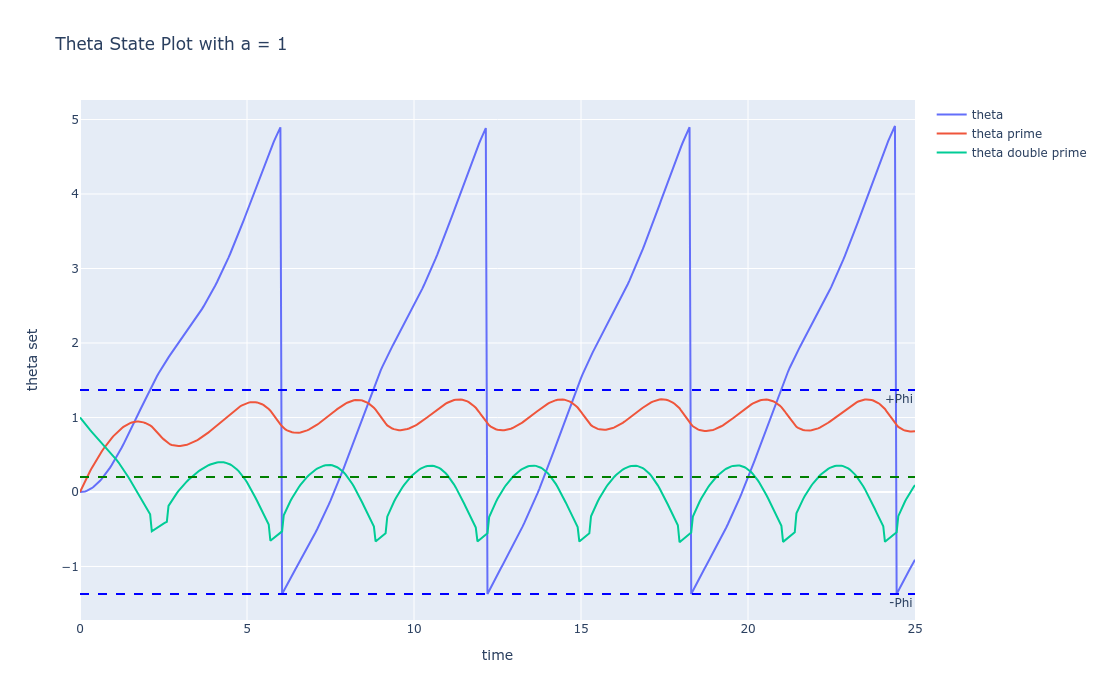

In [133]:
fig_len= 700
fig = go.Figure()
fig.update_layout(title = 'Theta State Plot with a = ' + str(a), xaxis_title = 'time', yaxis_title = 'theta set',
                  height = fig_len, width = fig_len + 200
                 )

fig.add_trace(go.Scatter(x=theta_set['time'], y = theta_set['theta'],
                    mode='lines',
                    name='theta'))
fig.add_trace(go.Scatter(x=theta_set['time'], y = theta_set['theta_prime'],
                    mode='lines',
                    name='theta prime'))
fig.add_trace(go.Scatter(x=theta_set['time'], y = theta_set['theta_double_prime'],
                    mode='lines',
                    name='theta double prime'))

fig.add_hline(y = -phi, line_dash = 'dash', line_color = 'blue',
                annotation_text = "-Phi", annotation_position="bottom right")
fig.add_hline(y = phi, line_dash = 'dash', line_color = 'blue',
                annotation_text = "+Phi", annotation_position="bottom right")

#initial acceleration
fig.add_hline(y = F_0 /(m*R) * np.cos(phi), line_dash = 'dash', line_color = 'green')

fig.show()